In [1]:
from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
from ic.candid import encode, Types
from meta.peaks_env import CryptoTradingEnv
from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators
import numpy as np
import pandas as pd
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import quantstats as qs
from utils.charts.plot_data_with_rsi import plot_data_with_rsi
from scipy.signal import find_peaks
from simulations.BuySellSimulation import BuySellStrategy

In [3]:
CANISTER_ID = "bkyz2-fmaaa-aaaaa-qaaaq-cai"
IC_URL = "http://127.0.0.1:4943"
OK_KEY = '_17724'
BUY_KEY = '_803992927'
HOLD_KEY = '_3308326'
SELL_KEY = '_925480882'

DECODE_DICT = {
    BUY_KEY: 0,
    HOLD_KEY: 1,
    SELL_KEY: 2
}

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output, display

def decode_action(response):
    """Decode action from IC canister response"""
    result_variant = response[0]['value']
    if list(result_variant.keys())[0] != OK_KEY:
        raise ValueError("Invalid response")
    action_variant = DECODE_DICT[list(result_variant[OK_KEY].keys())[0]]
    return action_variant

def predict_ic(obs) -> int:
    """Get prediction from IC canister"""
    # Extract prices and portfolio from observation
    prices = obs['prices'].astype(np.float32).flatten().tolist()
    portfolio = obs['portfolio'].astype(np.float32).flatten().tolist()

    # Prepare parameters for canister call
    params = [
        {"type": Types.Vec(Types.Float32), "value": prices},
        {"type": Types.Vec(Types.Float32), "value": portfolio}
    ]
    
    # Setup IC client and make call
    client = Client(url=IC_URL)
    identity = Identity()
    agent = Agent(identity, client)
    
    response = agent.update_raw(CANISTER_ID, "get_action", encode(params))
    return decode_action(response)

# ====================================
# Model Evaluation
# ====================================

# Load test data
test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-08-01', '1d', ['RSI', 'EMA_50'])
test_data = test_data.copy()
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)
peaks, properties = find_peaks(test_data['Close'], height=100, prominence=5, distance=40)
test_data['Peak'] = 0
test_data.loc[test_data.index[peaks], 'Peak'] = 1
num_features = 5

# Setup environment
eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
obs = eval_env.reset()
portfolio_values = []

done = False

while not done:
    # Get prediction from IC canister
    action = predict_ic(obs)  # Use obs[0] since env is vectorized
    
    # Step through environment
    obs, rewards, done, info = eval_env.step([action])
    portfolio_values.append(info[0]['net_worth'])
    
    eval_env.render()
    
    if done[0]:
        actions_history = info[0]['actions_history']
        print('Episode done!')

eval_env.close()


# ====================================
# Portfolio Analysis
# ====================================

actions_history.index = pd.to_datetime(test_data.index)
plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")  # Changed to hourly frequency
portfolio_series = pd.Series(portfolio_values, index=dates)
returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

[*********************100%***********************]  1 of 1 completed


Step: 11, Net Worth: 999.0, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 5.57757421875, Last Action: 1, Avg Buy Price: 0, Avg Sell Price: 0


KeyboardInterrupt: 

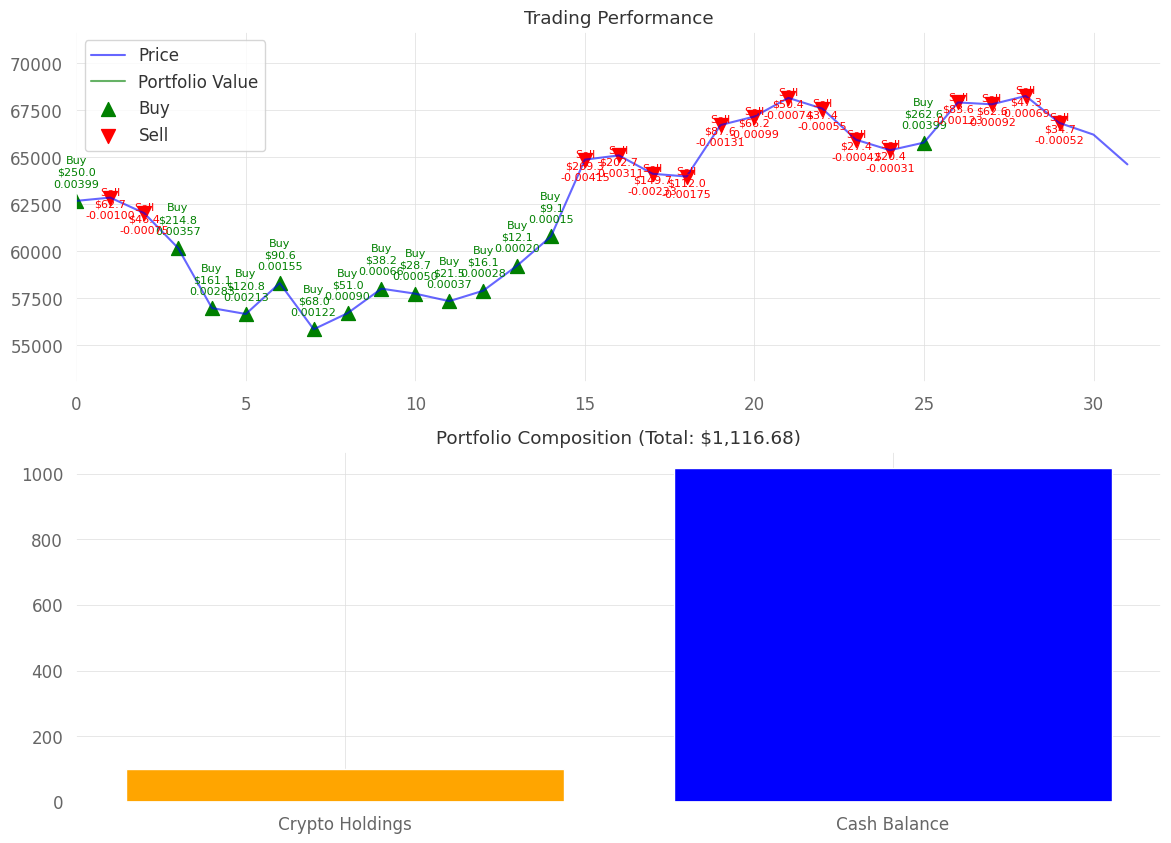


Simulation completed!
Final Portfolio Value: $1116.68
Total Transactions: 32


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time  
from IPython.display import clear_output, display
import quantstats as qs

def run_trading_session(initial_balance, risk_level='medium'):
    """Run an interactive trading session with real-time animations"""
    # Setup environment
    test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-08-01', '1d', ['RSI', 'EMA_50'])
    test_data = test_data.copy()
    test_data['Pct Change'] = test_data['Close'].pct_change() * 100
    test_data.dropna(inplace=True)
    peaks, properties = find_peaks(test_data['Close'], height=100, prominence=5, distance=40)
    test_data['Peak'] = 0
    test_data.loc[test_data.index[peaks], 'Peak'] = 1

    portfolio = BuySellStrategy(initial_balance, risk_level)
    eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
    
    obs = eval_env.reset()
    done = False
    
    # Initialize data storage
    prices = []
    portfolio_values = []
    actions = []
    transactions = []
    buys = []
    sells = []
    
    # Initialize the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    done = False
    k = 0

    while not done:   
        action = predict_ic(obs)
        current_price = eval_env.env_method('current_price')[0]
        # Execute trade
        portfolio.interpret_action(action, current_price)
        
        # Track metrics
        total_value = portfolio.balance + (portfolio.crypto_held * current_price)
        portfolio_values.append(total_value)
        prices.append(current_price)
        actions.append(action)
        transactions.append(portfolio.transaction_history[-1])
        
        # Record buy/sell actions
        if action == 1:
            buys.append(k)
        elif action == 2:
            sells.append(k)
        
        k = k + 1
        # Step environment
        obs, rewards, done, info = eval_env.step([action])

        # Clear previous output
        clear_output(wait=True)
        
        # Update the first subplot (Price and Portfolio Value)
        ax1.clear()
        ax1.plot(prices, label='Price', color='blue', alpha=0.6)
        ax1.plot(portfolio_values, label='Portfolio Value', color='green', alpha=0.6)
      
        # Scatter buys and sells
        if buys:
            buy_prices = [prices[i] for i in buys]
            ax1.scatter(buys, buy_prices, color='green', marker='^', label='Buy', s=100)
            # Annotate all buy points
            for i in buys:
                trade = transactions[i]
                ax1.annotate(f"Buy\n${trade.get('trade_amount', 0):.1f}\n{trade.get('traded_crypto', 0):.5f}",
                            (i, prices[i]),  # Use the actual point coordinates
                            textcoords="offset points",
                            xytext=(0,10),
                            ha='center',
                            fontsize=8,
                            color='green')

        if sells:
            sell_prices = [prices[i] for i in sells]
            ax1.scatter(sells, sell_prices, color='red', marker='v', label='Sell', s=100)
            # Annotate all sell points
            for i in sells:
                trade = transactions[i]
                ax1.annotate(f"Sell\n${trade.get('trade_amount', 0):.1f}\n{trade.get('traded_crypto', 0):.5f}",
                            (i, prices[i]),  # Use the actual point coordinates
                            textcoords="offset points",
                            xytext=(0,-15),
                            ha='center',
                            fontsize=8,
                            color='red')
                
        ax1.set_xlim(0, len(prices))
        ax1.set_ylim(min(prices) * 0.95, 
                     max(prices) * 1.05) 
        ax1.set_title('Trading Performance')
        ax1.legend(loc='upper left')
        ax1.grid(True)
        
        # # Update the second subplot (Portfolio Composition)
        ax2.clear()
        current_transaction = transactions[-1]
        crypto_value = current_transaction.get('crypto_held', 0) * current_price
        cash_balance = current_transaction.get('balance', 0)
        
        ax2.bar(['Crypto Holdings', 'Cash Balance'], 
                [crypto_value, cash_balance],
                color=['orange', 'blue'])
        ax2.set_title(f'Portfolio Composition (Total: ${crypto_value + cash_balance:,.2f})')
        ax2.grid(True)

        # Render the plot
        display(fig)
        
        plt.pause(0.001)  # Brief pause to ensure the plot updates

        
    plt.ioff()  # Disable interactive mode
    plt.show()
    
    return {
        'portfolio_values': portfolio_values,
        'prices': prices,
        'actions': actions,
        'transactions': transactions
    }
    

def generate_performance_report(results):
    """Generate a comprehensive performance report using quantstats"""
    portfolio_series = pd.Series(results['portfolio_values'])
    portfolio_series.index = pd.date_range(start='2024-05-01', periods=len(portfolio_series), freq='1H')
    returns = portfolio_series.pct_change().fillna(0)
    
    qs.reports.basic(returns, title='Trading Strategy Performance Report')

# Enable interactive mode (though not strictly necessary with IPython display)
plt.ion()

# Execute Trading Session with Real-Time Animation
initial_balance = 1000.0  # Example initial balance in USD
risk_level = 'medium'

print("\nStarting simulation with real-time visualization...")
results = run_trading_session(initial_balance, risk_level)
print("\nSimulation completed!")
print(f"Final Portfolio Value: ${results['portfolio_values'][-1]:.2f}")
print(f"Total Transactions: {len(results['transactions'])}")